In [1]:
! git clone https://github.com/gpauloski/kfac_pytorch.git
! pip install ./kfac_pytorch

fatal: destination path 'kfac_pytorch' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Processing ./kfac_pytorch
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for kfac-pytorch: filename=kfac_pytorch-0.4.1-py2.py3-none-any.whl size=46268 sha256=c29841468a273a38515f671fb70fa6a362d3861e541a7d68fe40cab7318a1c69
  Stored in directory: /tmp/pip-ephem-wheel-cache-1_32n4zl/wheels/02/e3/8d/9cea3dc920ea6134a9a6010384a614c48802250e8ad04710e0
Successfully built kfac-pytorch


In [1]:
#from kfac.preconditioner import KFACPreconditioner

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from itertools import product
from torch import tensor
import pickle
import time 
import matplotlib.pyplot as plt
import torchvision.datasets

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', train=True, download=True )
MNIST_test = torchvision.datasets.MNIST('./', train=False)
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
X_val = X_train[-5000:]
y_val = y_train[-5000:]

X_train = X_train[:-5000]
y_train = y_train[:-5000]

In [7]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [5]:
resume = True

if resume: 
    with open('kfc_small_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_kfc = arr["acc"]
        test_loss_history_kfc = arr["loss"]
        loss_in_training_kfc = arr["loss_train"]
        time_learning_kfc = arr["time"]
else:
    test_accuracy_history_kfc, test_loss_history_kfc, loss_in_training_kfc, time_learning_kfc = {}, {}, {}, {}

In [9]:
for learning_rate, weight_decay in product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4, 0]):
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_kfc:
        print("Already computed, ignoring")
        continue
    
    lenet5 = LeNet5()
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(lenet5.parameters(), lr=learning_rate, weight_decay=weight_decay)
    preconditioner = KFACPreconditioner(lenet5)
    
    batch_size = 100
    test_loss_history_kfc[key] = list()
    test_accuracy_history_kfc[key] = list()
    loss_in_training_kfc[key] = list()
    time_learning_kfc[key] = list()

    for epoch in range(20):
        order = np.random.permutation(len(X_train))
        start_time = time.time()
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
        
            batch_indexes = order[start_index:start_index+batch_size]
        
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
        
            preds = lenet5.forward(X_batch) 
        
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            
            preconditioner.step()
            
            optimizer.step()
        
        time_learning_kfc[key].append(time.time() - start_time)
        loss_in_training_kfc[key].append(loss(lenet5.forward(X_train), y_train).data)
        
        test_preds = lenet5.forward(X_val)
        test_loss_history_kfc[key].append(loss(test_preds, y_val).data)
    
        accuracy = (test_preds.argmax(dim=1) == y_val).float().mean().data
        test_accuracy_history_kfc[key].append(accuracy)
        
    print(test_accuracy_history_kfc[(learning_rate, weight_decay)])
    print(loss_in_training_kfc[(learning_rate, weight_decay)])
    with open('kfc_small_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_kfc, "loss": test_loss_history_kfc, "loss_train":loss_in_training_kfc, "time":time_learning_kfc}, f)

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
for param, accuracy in test_accuracy_history_kfc.items():
    plt.plot(accuracy, label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

In [6]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

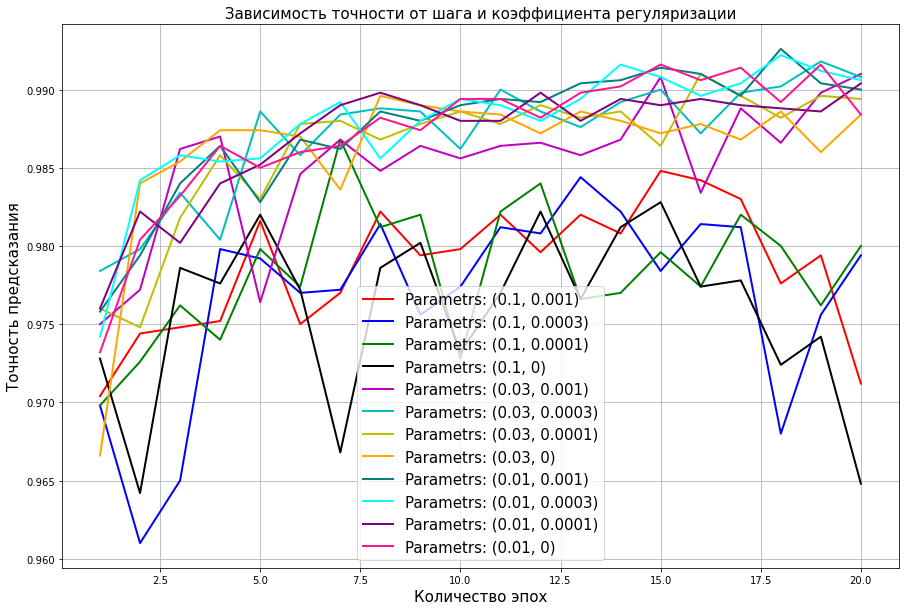

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_kfc.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('kfc_1_accrucy.png')

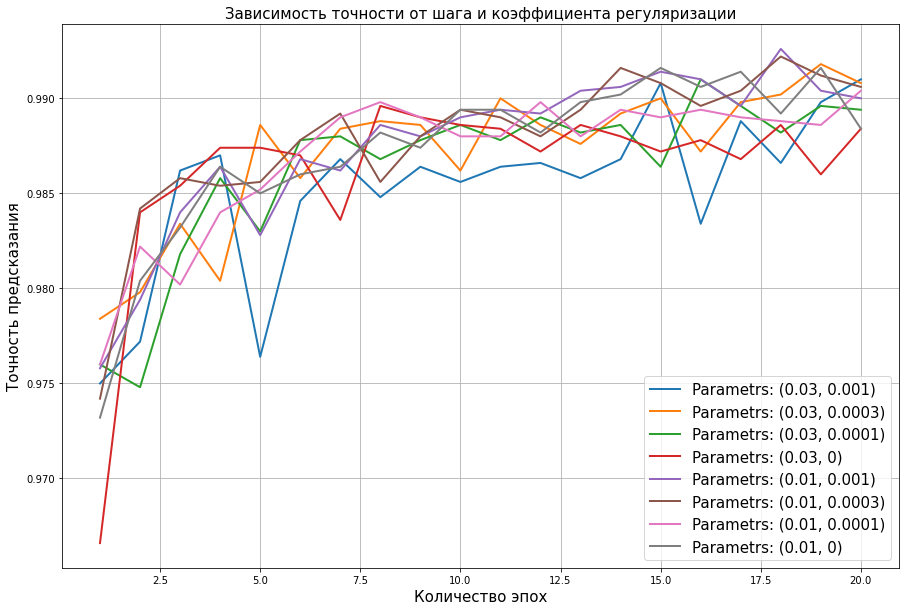

In [8]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
for  param in product([0.03, 0.01], [1e-3, 3e-4, 1e-4, 0]):
    plt.plot(range(1, 21), test_accuracy_history_kfc[param], label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('kfc_1_accrucy_small.png')

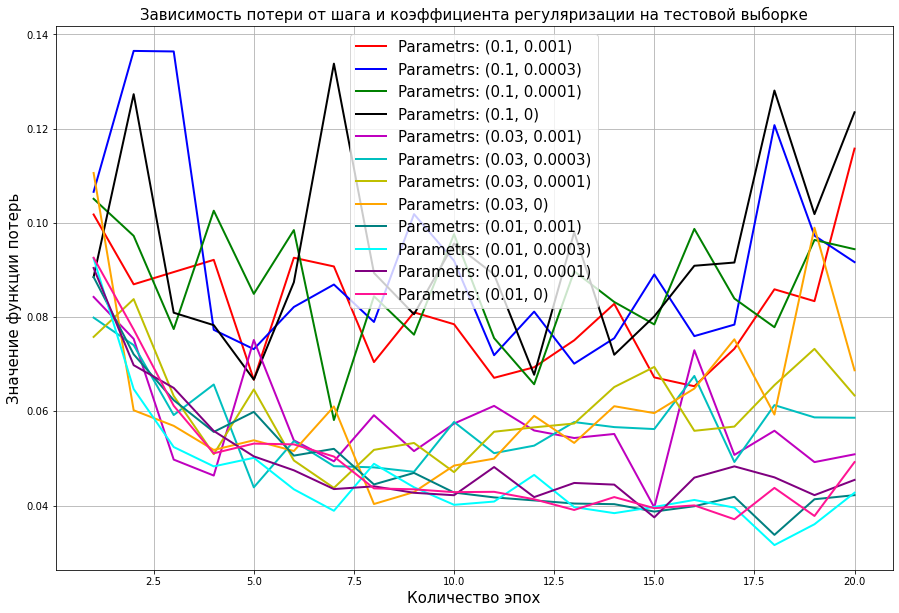

In [9]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_kfc.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('kfc_1_loss.png')

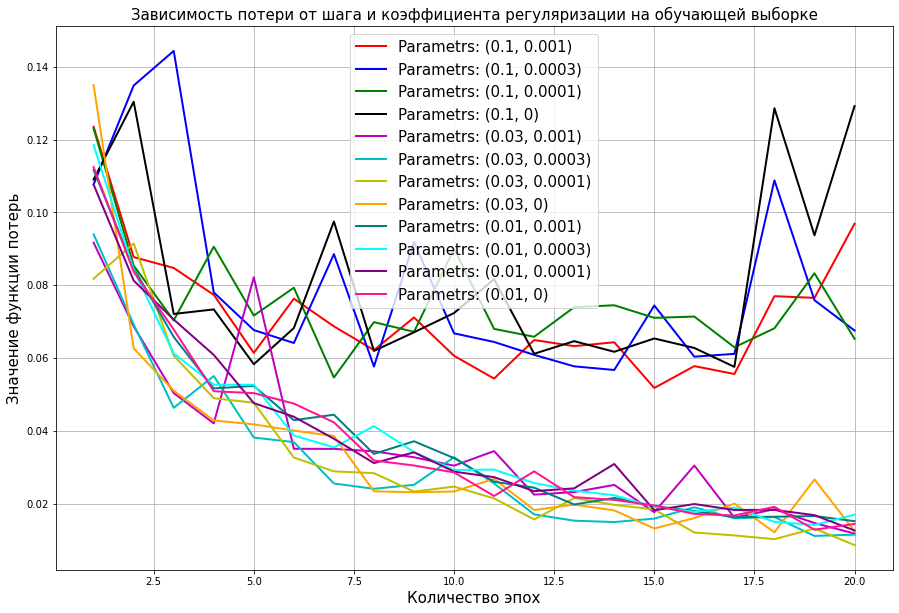

In [10]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_kfc.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('kfc_1_loss_train.png')

In [16]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [17]:
lenet5 = LeNet5()
loss = torch.nn.CrossEntropyLoss()
    
optimizer = torch.optim.SGD(lenet5.parameters(), lr=0.01, weight_decay=0.0003)
preconditioner = KFACPreconditioner(lenet5)
    
batch_size = 100
test_loss_history_kfc = list()
test_accuracy_history_kfc = list()
loss_in_training_kfc = list()
time_learning_kfc = list()

for epoch in range(20):
    order = np.random.permutation(len(X_train))
    
    start_time = time.time()
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
            
        preconditioner.step()
            
        optimizer.step()
    
    time_learning_kfc.append(time.time() - start_time)
    loss_in_training_kfc.append(loss(lenet5.forward(X_train), y_train).data)
        
    test_preds = lenet5.forward(X_test)
    test_loss_history_kfc.append(loss(test_preds, y_test).data)
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy_history_kfc.append(accuracy)
    
print(test_accuracy_history_kfc)
print(loss_in_training_kfc)
with open('kfc_mini_results.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_kfc, "loss": test_loss_history_kfc, "loss_train":loss_in_training_kfc, "time":time_learning_kfc}, f)

[tensor(0.9734), tensor(0.9807), tensor(0.9788), tensor(0.9838), tensor(0.9849), tensor(0.9867), tensor(0.9867), tensor(0.9879), tensor(0.9873), tensor(0.9873), tensor(0.9888), tensor(0.9882), tensor(0.9857), tensor(0.9881), tensor(0.9883), tensor(0.9879), tensor(0.9905), tensor(0.9894), tensor(0.9887), tensor(0.9881)]
[tensor(0.1036), tensor(0.0664), tensor(0.0697), tensor(0.0512), tensor(0.0464), tensor(0.0368), tensor(0.0388), tensor(0.0326), tensor(0.0334), tensor(0.0293), tensor(0.0226), tensor(0.0274), tensor(0.0295), tensor(0.0206), tensor(0.0221), tensor(0.0262), tensor(0.0176), tensor(0.0159), tensor(0.0150), tensor(0.0167)]


In [11]:
with open('kfc_mini_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_kfc = arr["acc"]
        test_loss_history_kfc = arr["loss"]
        loss_in_training_kfc = arr["loss_train"]
        time_learning_kfc = arr["time"]

with open('adam_mini_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_adam = arr["acc"]
        test_loss_history_adam = arr["loss"]
        loss_in_training_adam = arr["loss_train"]
        time_learning_adam = arr["time"]
        
with open('sgd_mini_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sgd = arr["acc"]
        test_loss_history_sgd = arr["loss"]
        loss_in_training_sgd = arr["loss_train"]
        time_learning_sgd = arr["time"]

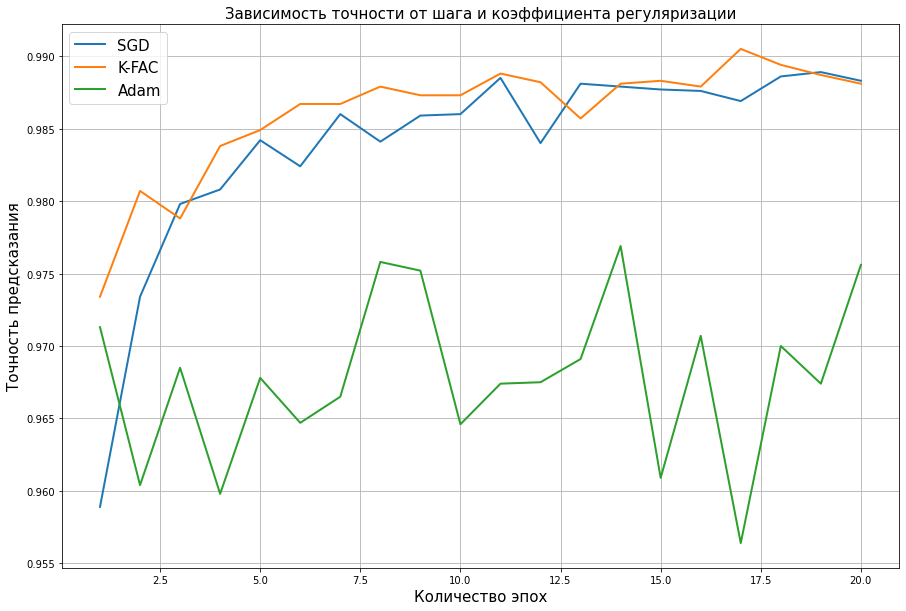

In [12]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)


plt.plot(range(1, 21), test_accuracy_history_sgd, label = 'SGD', linewidth=2)
plt.plot(range(1, 21), test_accuracy_history_kfc, label = 'K-FAC', linewidth=2)
plt.plot(range(1, 21), test_accuracy_history_adam, label = 'Adam', linewidth=2)

plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('exp_1_accrucy.png')

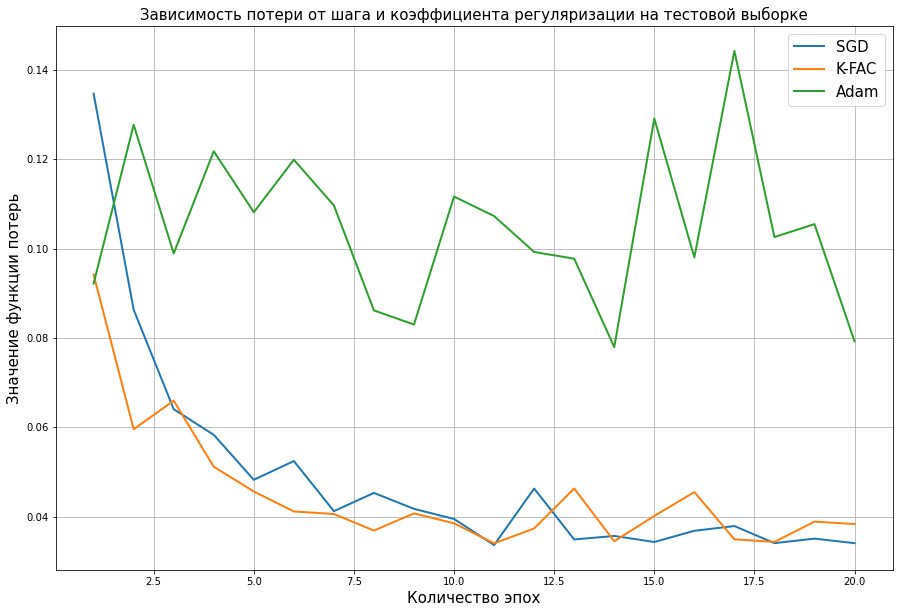

In [13]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)


plt.plot(range(1, 21), list(map(float, test_loss_history_sgd)), label = 'SGD', linewidth=2)
plt.plot(range(1, 21), list(map(float, test_loss_history_kfc)), label = 'K-FAC', linewidth=2)
plt.plot(range(1, 21), list(map(float, test_loss_history_adam)), label = 'Adam', linewidth=2)

plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('exp_1_loss.png')

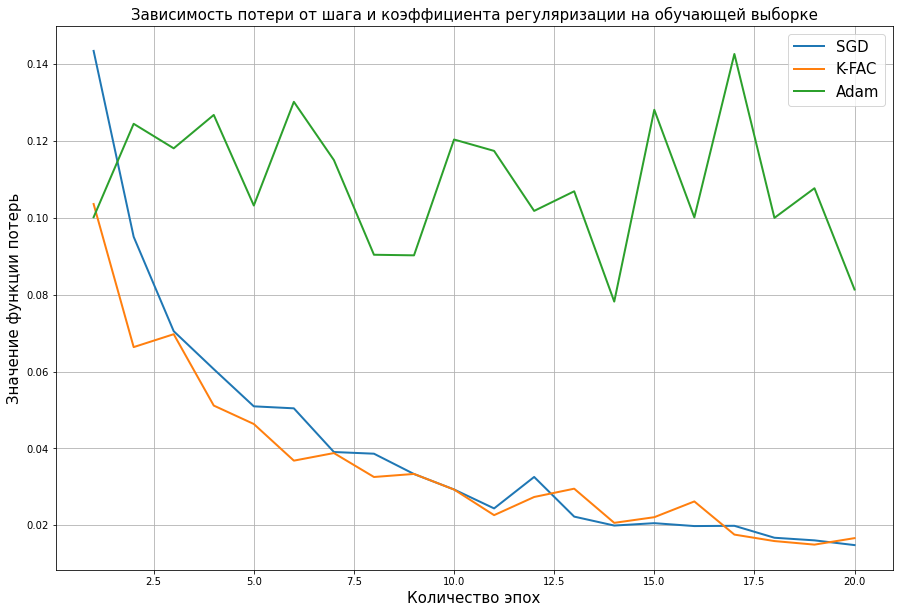

In [14]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)


plt.plot(range(1, 21), loss_in_training_sgd, label = 'SGD', linewidth=2)
plt.plot(range(1, 21), loss_in_training_kfc, label = 'K-FAC', linewidth=2)
plt.plot(range(1, 21), loss_in_training_adam, label = 'Adam', linewidth=2)

plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('exp_1_loss_train.png')

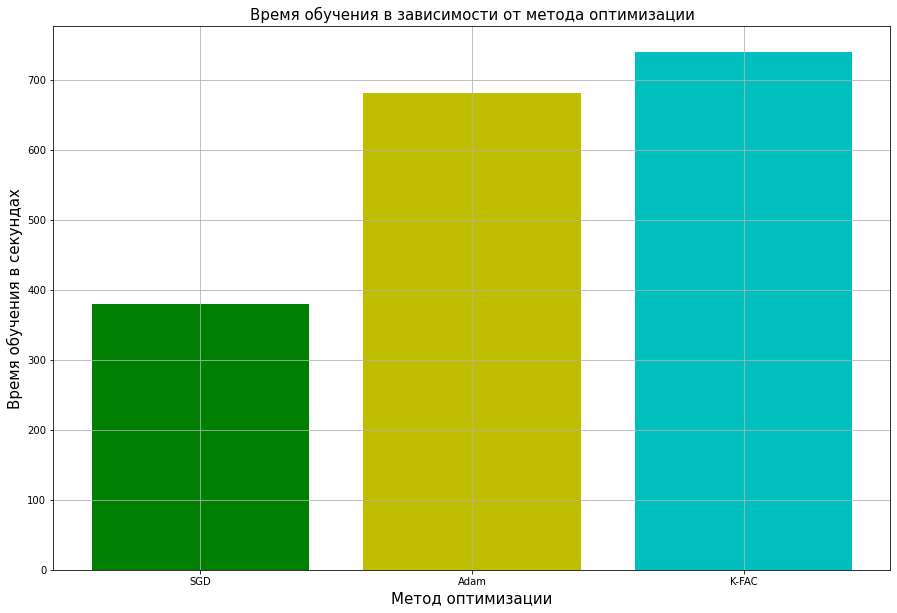

In [16]:
fig = plt.figure(figsize = (15, 10))
plt.title('Время обучения в зависимости от метода оптимизации', fontsize=15)
plt.xlabel('Метод оптимизации', fontsize=15)
plt.ylabel('Время обучения в секундах', fontsize=15)

x = ['SGD', 'Adam', 'K-FAC']
y = [sum(time_learning_sgd), sum(time_learning_adam), sum(time_learning_kfc)]

plt.bar(x, y, color = ['g', 'y', 'c'])

plt.grid(True)
plt.savefig('exp_1_time.png')